<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C8/C8.html"><img src="../data/C8_nav.png" width="100"  style="float:right;" alt="C8"></a>
<h1>Fundamental Frequency Tracking</h1> 
</div>

<br/>

<p>
Following Section 8.2.3 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we discuss in this notebook various variants for tracking the fundamental frequency.
</p> 

## Frequency Trajectory

In general terms, a [**melody**](../C8/C8S2_MelodyExtractSep.html) may be defined as a linear succession of musical tones that form a coherent entity and express a particular musical idea. As with many other concepts in music processing, the notion of melody remains rather vague (see the [FMP notebook on melody extraction and separation](../C8/C8S2_MelodyExtractSep.html) for a more detailed discussion). In this notebook, we consider the scenario where the music is given in the form of an audio recording (and not as a symbolic music representation). Furthermore, rather than estimating a sequence of notes, our objective is to determine a sequence of frequency values that correspond to the notes' pitches. Such a frequency path over time, which may also capture continuous frequency glides and modulations, is referred to as a **frequency trajectory**. In particular, we are interested in the [**fundamental frequency values**](../C1/C1S3_Timbre.html) (also called **F0-values**) of the melody's notes. The resulting trajectory is also called an **F0-trajectory**. Mathematically, we model an F0-trajectory to be a function

\begin{equation}
    \eta:\mathbb{R}\to\mathbb{R}\cup\{\ast\},
\end{equation}

which assigns to each time point $t\in\mathbb{R}$ (given in seconds) either a frequency value $\eta(t)\in\mathbb{R}$ (given in Hertz) or the symbol $\eta(n)=\ast$. The interpretation of $\eta(t)=\ast$ is that there is no F0-value corresponding to the melodic component at this time instance.

As an example, we consider a short excerpt of an aria from the opera "Der Freischütz" by Carl Maria von Weber, which we already used in the [FMP notebook on salience representations](../C8/C8S2_SalienceRepresentation.html). In the score representation, the main melody is notated in a separate staff line underlaid with lyrics. In a performance by a soprano singer, the melody corresponds to a trajectory of F0-values. As opposed to the notated symbolic representation, some of the notes are smoothly connected. Furthermore, one can observe rather pronounced frequency modulations due to vibrato. 

<img src="../data/C8/FMP_C8_F10a.png" width="300px" align="left" alt="FMP_C8_F10a">
<!--<img src="../data/C8/FMP_C8_F10.png" width="300px" align="left" alt="FMP_C8_F10">-->

<br clear="all" />

<audio style="width: 300px;" src="../data/C8/FMP_C8_F10_Weber_Freischuetz-06_FreiDi-35-40.wav" type="audio/mpeg" controls="controls"></audio>

In the following figure, we visualize the F0-trajectory of the singer (read from an annotation file), one with a linear frequency axis (given in Hertz) and once with a logarithmic frequency axis (given in cents relative to the reference frequency $\omega_\mathrm{ref}=55~\mathrm{Hz}$.

<!--<img src="../data/C8/FMP_C8_F10b-c.png" width="300px" align="middle" alt="FMP_C8_F10b-c">-->

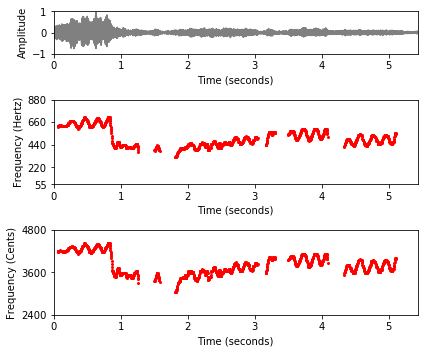

In [1]:
import numpy as np
import os, sys, librosa
import pandas as pd
from scipy import signal
from scipy import linalg
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import IPython.display as ipd
from numba import jit

sys.path.append('..')
import libfmp.b
import libfmp.c3
import libfmp.c8
%matplotlib inline

def hz_to_cents(F, F_ref=55.0):
    """Converts frequency in Hz to cents

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        F (float or np.ndarray): Frequency value in Hz
        F_ref (float): Reference frequency in Hz (Default value = 55.0)

    Returns:
        F_cent (float or np.ndarray): Frequency in cents
    """
    F_cent = 1200 * np.log2(F / F_ref)
    return F_cent

def cents_to_hz(F_cent, F_ref=55.0):
    """Converts frequency in cents to Hz

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        F_cent (float or np.ndarray): Frequency in cents
        F_ref (float): Reference frequency in Hz (Default value = 55.0)

    Returns:
        F (float or np.ndarray): Frequency in Hz
    """
    F = F_ref * 2 ** (F_cent / 1200)
    return F

# Load audio
fn_wav = os.path.join('..', 'data', 'C8', 'FMP_C8_F10_Weber_Freischuetz-06_FreiDi-35-40.wav')
Fs = 22050
x, Fs = librosa.load(fn_wav, sr=Fs)
x_duration = len(x)/Fs
ipd.Audio(x, rate=Fs)

# Read in the F0 trajectory
fn_traj = os.path.join('..', 'data', 'C8', 'FMP_C8_F10_Weber_Freischuetz-06_FreiDi-35-40_F0-user-Book.csv')
traj_df = libfmp.b.read_csv(fn_traj)
traj = traj_df.values

fig, ax = plt.subplots(3, 1, gridspec_kw={'height_ratios': [1, 2, 2]}, figsize=(6,5))
libfmp.b.plot_signal(x, Fs, ax=ax[0], xlabel='');
ax[0].set_ylim((-1,1));
ax[0].set_ylabel('Amplitude')
ax[0].set_xlabel('Time (seconds)')

traj_plot = traj[traj[:, 1]>0]
ax[1].plot(traj_plot[:, 0], traj_plot[:, 1], color='r', markersize=4, marker='.', linestyle='');
ax[1].set_ylim((55,880));
ax[1].set_yticks([55, 220, 440, 660, 880])
ax[1].set_xlim((0, x_duration));
ax[1].set_ylabel('Frequency (Hertz)')
ax[1].set_xlabel('Time (seconds)')
plt.tight_layout()

ax[2].plot(traj_plot[:, 0], hz_to_cents(traj_plot[:, 1]), color='r', markersize=4, marker='.', linestyle='');
ax[2].set_ylim((2400, 4800));
ax[2].set_yticks([2400, 3600, 4800])
ax[2].set_xlim((0, x_duration));
plt.xlabel('Time (seconds)')
ax[2].set_ylabel('Frequency (Cents)')
plt.tight_layout()

In [2]:
import os

os.getcwd()

'/home/ssl/Documents/Acads/HS 4114/FMP/Project'

## Sonification of Frequency Trajectories

In the following code cell, we provide a function for sonifying a given frequency trajectory using sinusoids. 

In [3]:
def sonify_trajectory_with_sinusoid(traj, audio_len, Fs=22050, amplitude=0.3, smooth_len=11):
    """Sonification of trajectory with sinusoidal

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        traj (np.ndarray): F0 trajectory (time in seconds, frequency in Hz)
        audio_len (int): Desired audio length in samples
        Fs (scalar): Sampling rate (Default value = 22050)
        amplitude (float): Amplitude (Default value = 0.3)
        smooth_len (int): Length of amplitude smoothing filter (Default value = 11)

    Returns:
        x_soni (np.ndarray): Sonification
    """
    # unit confidence if not specified
    if traj.shape[1] < 3:
        confidence = np.zeros(traj.shape[0])
        confidence[traj[:, 1] > 0] = amplitude
    else:
        confidence = traj[:, 2]

    # initialize
    x_soni = np.zeros(audio_len)
    amplitude_mod = np.zeros(audio_len)

    # Computation of hop size
    # sine_len = int(2 ** np.round(np.log(traj[1, 0]*Fs) / np.log(2)))
    sine_len = int(traj[1, 0] * Fs)

    t = np.arange(0, sine_len) / Fs
    phase = 0

    # loop over all F0 values, insure continuous phase
    for idx in np.arange(0, traj.shape[0]):
        cur_f = traj[idx, 1]
        cur_amp = confidence[idx]

        if cur_f == 0:
            phase = 0
            continue

        cur_soni = np.sin(2*np.pi*(cur_f*t+phase))
        diff = np.maximum(0, (idx+1)*sine_len - len(x_soni))
        if diff > 0:
            x_soni[idx * sine_len:(idx + 1) * sine_len - diff] = cur_soni[:-diff]
            amplitude_mod[idx * sine_len:(idx + 1) * sine_len - diff] = cur_amp
        else:
            x_soni[idx*sine_len:(idx+1)*sine_len-diff] = cur_soni
            amplitude_mod[idx*sine_len:(idx+1)*sine_len-diff] = cur_amp

        phase += cur_f * sine_len / Fs
        phase -= 2 * np.round(phase/2)

    # filter amplitudes to avoid transients
    amplitude_mod = np.convolve(amplitude_mod, np.hanning(smooth_len)/np.sum(np.hanning(smooth_len)), 'same')
    x_soni = x_soni * amplitude_mod
    return x_soni


x_traj_mono = sonify_trajectory_with_sinusoid(traj, len(x), Fs, smooth_len=11, amplitude=0.6)
# left: x, right: sonification
x_traj_stereo = np.vstack((x.reshape(1,-1), x_traj_mono.reshape(1,-1)))  

print('F0 sonification (mono)')
ipd.display(ipd.Audio(x_traj_mono, rate=Fs))
print('F0 sonification superimposed with original recording (mono)')
ipd.display(ipd.Audio( (x_traj_mono+x)/2, rate=Fs))
print('F0 sonification (right channel), original recording (left channel)')
ipd.display(ipd.Audio(x_traj_stereo, rate=Fs))

F0 sonification (mono)


F0 sonification superimposed with original recording (mono)


F0 sonification (right channel), original recording (left channel)


## Salience-Based Frequency Tracking

Often, the [**main melody**](../C8/C8S2_MelodyExtractSep.html) of a song is dominant in the sense that it is the strongest harmonic source in the given audio signal. In the following, we restrict ourselves to music where the melody is predominantly being performed by a lead singer or a lead instrument. In particular, we assume that there is only one melody line at a time, which can be associated to a single sound source. In this scenario, to extract the main melody, one simple approach is to look for the strongest harmonic frequency component for each time frame. Recall that the goal of designing the [salience representation](../C8/C8S2_SalienceRepresentation.html) (Section 8.2.2 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>) was to enhance such harmonic components. Therefore, a first strategy for melody extraction is to simply consider the frame-wise maximum of the salience representation.

We now formalize this procedure. In the following, let $\mathcal{Z}$ denote a [salience representation](../C8/C8S2_SalienceRepresentation.html) with entries $\mathcal{Z}(n,b)\in\mathbb{R}$, where $n\in[1:N]$ denotes the frame index and $b\in[1:B]$ the bin index. In the following, we use the salience representation of our Freischütz example as computed in the next code cell. The visualization function also provides functionalities to show additional elements (e.g., trajectories, constraint regions) on top of the salience representation. 

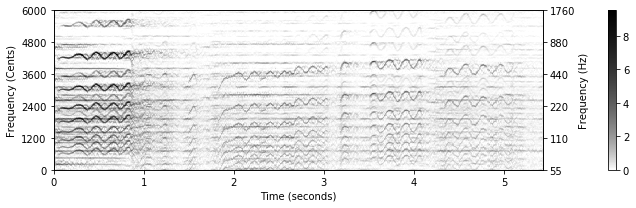

In [4]:
def visualize_salience_traj_constraints(Z, T_coef, F_coef_cents, F_ref=55.0, colorbar=True, cmap='gray_r',
                                        figsize=(7, 4), traj=None, constraint_region=None, ax=None):
    """Visualize salience representation with optional F0-trajectory and constraint regions

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        Z: Salience representation
        T_coef: Time axis
        F_coef_cents: Frequency axis in cents
        F_ref: Reference frequency (Default value = 55.0)
        colorbar: Show or hide colorbar (Default value = True)
        cmap: Color map (Default value = 'gray_r')
        figsize: Figure size (Default value = (7, 4))
        traj: F0 trajectory (time in seconds, frequency in Hz) (Default value = None)
        constraint_region: Constraint regions, row-format: (t_start_sec, t_end_sec, f_start_hz, f_end,hz)
            (Default value = None)
        ax: Handle to existing axis (Default value = None)

    Returns:
        fig: Handle to figure
        ax: Handle to cent axis
        ax_f: Handle to frequency axis
    """
    fig = None
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    sal = ax.imshow(Z, extent=[T_coef[0], T_coef[-1], F_coef_cents[0], F_coef_cents[-1]],
                    cmap=cmap, origin='lower', aspect='auto', interpolation='nearest')

    y_ticklabels_left = np.arange(F_coef_cents[0], F_coef_cents[-1]+1, 1200)
    ax.set_yticks(y_ticklabels_left)
    ax.set_yticklabels(y_ticklabels_left)
    ax.set_ylabel('Frequency (Cents)')

    if colorbar:
        plt.colorbar(sal, ax=ax, pad=0.1)

    ax_f = ax.twinx()  # instantiate a second axes that shares the same y-axis
    ax_f.set_yticks(y_ticklabels_left - F_coef_cents[0])
    y_ticklabels_right = cents_to_hz(y_ticklabels_left, F_ref).astype(int)
    ax_f.set_yticklabels(y_ticklabels_right)
    ax_f.set_ylabel('Frequency (Hz)')

    # plot contour
    if traj is not None:
        traj_plot = traj[traj[:, 1] > 0, :]
        traj_plot[:, 1] = hz_to_cents(traj_plot[:, 1], F_ref)
        ax.plot(traj_plot[:, 0], traj_plot[:, 1], color='r', markersize=4, marker='.', linestyle='')

    # plot constraint regions
    if constraint_region is not None:
        for row in constraint_region:
            t_start = row[0]  # sec
            t_end = row[1]  # sec
            f_start = row[2]  # Hz
            f_end = row[3]  # Hz
            ax.add_patch(matplotlib.patches.Rectangle((
                t_start, hz_to_cents(f_start, F_ref)), width=t_end-t_start,
                height=hz_to_cents(f_end, F_ref)-hz_to_cents(f_start, F_ref),
                fill=False, edgecolor='k', linewidth=3, zorder=2))

    ax.set_xlabel('Time (seconds)')

    if fig is not None:
        plt.tight_layout()

    return fig, ax, ax_f

# Computation of salience representation
N = 1024
H = 128
R = 10
F_min = 55.0
F_max = 1760.0
num_harm = 8
freq_smooth_len = 11
alpha = 0.9
gamma = 0.1

Z, F_coef_hertz, F_coef_cents = libfmp.c8.compute_salience_rep(x, Fs, N=N, H=H, R=R, 
                    F_min=F_min, F_max=F_max, num_harm=num_harm, 
                    freq_smooth_len=freq_smooth_len, alpha=alpha, gamma=gamma)
T_coef = (np.arange(Z.shape[1]) * H) / Fs

# Visualization
figsize = (10,3)
cmap = libfmp.b.compressed_gray_cmap(alpha=5)
visualize_salience_traj_constraints(Z, T_coef, F_coef_cents, F_ref=F_min, figsize=figsize, cmap=cmap, 
                                    colorbar=True, ax=None)
plt.show()

In the discrete setting, the **frequency trajectory** is defined to be a function 

\begin{equation}
    \eta:[1:N]\to[1:B]\cup\{\ast\}
\end{equation}

which assigns to each frame index $n\in[1:N]$ either a bin index $\eta(n)\in[1:B]$ or the symbol $\eta(n)=\ast$. Taking the maximizing bin index of $\mathcal{Z}$ for each frame yields a frequency trajectory $\eta^\mathrm{max}$ defined by

\begin{equation}
    \eta^\mathrm{max}(n):=  \underset{b\in[1:B]}{\mathrm{argmax}}\,\, \mathcal{Z}(n,b).
\end{equation}

The next figure illustrates this simple F0-trajectory tracking procedure continuing our Freischütz example. Note that one can observe a number of outliers and temporal discontinuities. Furthermore, the proposed method assigns an F0-value to each time frame, regardless of whether the melody is actually present or not.

<!--<img src="../data/C8/FMP_C8_F16a.png" width="400px" align="middle" alt="FMP_C8_F16a">-->

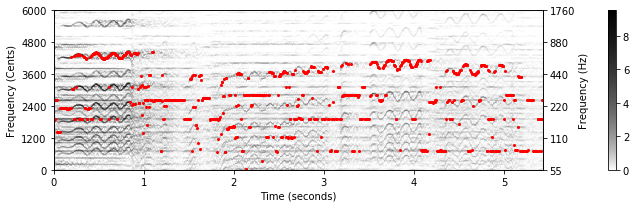

F0 sonification (right channel), original recording (left channel)


In [5]:
# Frequency trajectory via maximization
index_max = np.argmax(Z, axis=0)
traj = np.hstack((T_coef.reshape(-1, 1), F_coef_hertz[index_max].reshape(-1, 1)))

# Visualization
figsize = (10,3)
cmap = libfmp.b.compressed_gray_cmap(alpha=5)
visualize_salience_traj_constraints(Z, T_coef, F_coef_cents, F_ref=F_min, figsize=figsize, cmap=cmap, 
                                    colorbar=True, traj=traj, ax=None)
plt.show()

# Sonification
x_traj_mono = sonify_trajectory_with_sinusoid(traj, len(x), Fs, smooth_len=11)
x_traj_stereo = np.vstack((x.reshape(1,-1), x_traj_mono.reshape(1,-1)))  
print('F0 sonification (right channel), original recording (left channel)')
ipd.display(ipd.Audio(x_traj_stereo, rate=Fs))

## Continuity Constraints

Computing a frequency trajectory in a purely frame-wise fashion without considering any temporal context can lead to local discontinuities and random jumps. In practice, however, a melody's frequency trajectory is far more structured. Typically, it slowly changes over time with some occasional jumps between note transitions. We now discuss a procedure  that can balance out the two conflicting conditions of **temporal flexibility** (to account for possible jumps) and **temporal continuity** (to account for smoothness properties). Let $\mathcal{Z}$ be a salience representation that consists of $N$ time frames and $B$ frequency bins. The value $\mathcal{Z}(n,b)$ can be regarded as a **score** which expresses the likelihood that a frequency associated to bin $b\in[1:B]$ belongs to a dominating tonal component at time $n\in[1:N]$. Furthermore, let 

$$
T\in\mathbb{R}^{B\times B}
$$ 

be **transition** matrix, where an entry $T(b,c)\in\mathbb{R}$ expresses some kind of likelihood for moving from bin $b\in[1:B]$ at time frame $n\in[1:N-1]$ to bin $c\in[1:B]$ at time frame $n+1$. There are many ways for defining such a transition matrix. The main idea is that $T$ should favor transitions between close-by bins (e.g., $\mathbf{T}(b,c)\approx 1$  when $|b-c|$ is small) and punish transitions between far-apart bins (e.g., $\mathbf{T}(b,c)\approx \delta$ for a small positive number $\delta>0$ when $|b-c|$ is large). For example, one may want to favor small fluctuations of up to $\pm 50$ cents, while being indifferent to larger deviations. We define in the next code cell a transition matrix $T$ that satisfies these requirements.

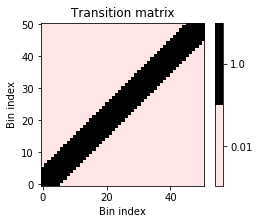

In [6]:
# @jit(nopython=True)
def define_transition_matrix(B, tol=0, score_low=0.01, score_high=1.0):
    """Generate transition matrix

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        B (int): Number of bins
        tol (int): Tolerance parameter for transition matrix (Default value = 0)
        score_low (float): Score (low) for transition matrix (Default value = 0.01)
        score_high (float): Score (high) for transition matrix (Default value = 1.0)

    Returns:
        T (np.ndarray): Transition matrix
    """
    col = np.ones((B,)) * score_low
    col[0:tol+1] = np.ones((tol+1, )) * score_high
    T = linalg.toeplitz(col)
    return T

# Compute transition matrix
T = define_transition_matrix(B=51, tol=5)

# Plot
colorList = np.array([[1,0.9,0.9,1],[0,0,0,1]])
cmap = ListedColormap(colorList) 
plt.figure(figsize=(4,3))
im = plt.imshow(T, origin='lower', cmap=cmap)
plt.title('Transition matrix')
plt.xlabel('Bin index')
plt.ylabel('Bin index')
ax_cb = plt.colorbar(im)
ax_cb.set_ticks(np.array([0.25, 0.75]))
ax_cb.set_ticklabels(np.array([np.min(T), np.max(T)])) 

Given a salience representation $\mathcal{Z}$ and a transition likelihood matrix $\mathbf{T}$, we can associate to each trajectory $\eta:[1:N]\to[1:B]$ a **total score** $\sigma(\eta)$ by setting 

\begin{equation}
    \sigma(\eta) := \mathcal{Z}(1,\eta(1)) \cdot \prod_{n=2}^{N} \Big(\mathbf{T}(\eta(n-1),\eta(n))\cdot \mathcal{Z}(n,\eta(n))\Big).
\end{equation}

The desired trajectory $\eta^\mathrm{DP}$ is then defined to be the score-maximizing trajectory:

\begin{equation}
    \eta^\mathrm{DP} := \underset{\eta}{\mathrm{argmax}} \,\, \sigma(\eta).
\end{equation}

The maximal total score can be computed via dynamic programming (similar to the [Viterbi algorithm](../C5/C5S3_HiddenMarkovModel.html)). Furthermore, the trajectory $\eta^\mathrm{DP}$ is obtained by applying a suitable backtracking procedure. When computing products with many factors, one often encounters **numerical instabilities**  (e.g., **underflow problems** where products approach zero). Therefore, in practice, one should implement the optimization approach in the **log domain**, where products become sums. Such an approach is used in the following implementation. The figure shows the result for our Freischütz example. Note that, compared to the simple maximizing approach, most outliers have been eliminated thanks to the continuity constraints introduced by the transition likelihoods. However, tracking errors still occur when the accompaniment exhibits tonal components that are stronger than the ones of the melody. 

<!--
The algorithm woks as follows:
<img src="../data/C8/FMP_C8_E12.png" width="500px" align="middle" alt="FMP_C8_E12.png">
-->

<!--<img src="../data/C8/FMP_C8_F16b.png" width="400px" align="middle" alt="FMP_C8_F16b">-->

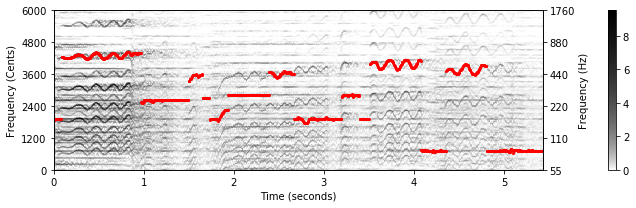

F0 sonification (right channel), original recording (left channel)


In [7]:
@jit(nopython=True)
def compute_trajectory_dp(Z, T):
    """Trajectory tracking using dynamic programming

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        Z: Salience representation
        T: Transisition matrix

    Returns:
        eta_DP (np.ndarray): Trajectory indices
    """
    B, N = Z.shape
    eps_machine = np.finfo(np.float32).eps
    Z_log = np.log(Z + eps_machine)
    T_log = np.log(T + eps_machine)

    E = np.zeros((B, N))
    D = np.zeros((B, N))
    D[:, 0] = Z_log[:, 0]

    for n in np.arange(1, N):
        for b in np.arange(0, B):
            D[b, n] = np.max(T_log[b, :] + D[:, n-1]) + Z_log[b, n]
            E[b, n-1] = np.argmax(T_log[b, :] + D[:, n-1])

    # backtracking
    eta_DP = np.zeros(N)
    eta_DP[N-1] = int(np.argmax(D[:, N-1]))

    for n in np.arange(N-2, -1, -1):
        eta_DP[n] = E[int(eta_DP[n+1]), n]

    return eta_DP.astype(np.int64)

# Frequency trajectory via DP-based optimization
B, N = Z.shape
T = define_transition_matrix(B, tol=5)
index_DP =  compute_trajectory_dp(Z, T)

traj = np.hstack((T_coef.reshape(-1, 1), F_coef_hertz[index_DP].reshape(-1, 1)))

# Visualization
figsize = (10,3)
cmap = libfmp.b.compressed_gray_cmap(alpha=10)
visualize_salience_traj_constraints(Z, T_coef, F_coef_cents, F_ref=F_min, 
                                    figsize=figsize, cmap=cmap, 
                                    colorbar=True, traj=traj, ax=None)
plt.show()

# Sonification
x_traj_mono = sonify_trajectory_with_sinusoid(traj, len(x), Fs, smooth_len=11)
x_traj_stereo = np.vstack((x.reshape(1,-1), x_traj_mono.reshape(1,-1)))  
print('F0 sonification (right channel), original recording (left channel)')
ipd.display(ipd.Audio(x_traj_stereo, rate=Fs))

## Score-Informed Constraints

Besides incorporating continuity constraints, another strategy is to exploit additional musical knowledge about the melodic progression to support the F0-tracking process.  For example, knowing the vocal range (soprano, alto, tenor, bass) of the singer, one may narrow down the search range of the expected F0-values. Or, having information about when the melody is actually present and when it is not, one can set all F0-values to the symbol '$\ast$' for the non-melody frames.

More generally, additional knowledge as described above can be used to define **constraint regions** within the time&ndash;frequency plane. The F0-tracking is then performed only in these specified regions. As an example of such an approach, we now discuss a **score-informed procedure**, where one assumes the availability of a score representation 
that underlies the given music recording. The additional instrumentation and note information provided  by the score can then be used to guide the estimation of the melody's F0-trajectory. In a first step, one needs to align the musical score and the given audio recording. This may be done in a manual annotation process or (semi-)automatically using [music synchronization techniques](../C3/C3_MusicSynchronization.html) (see Chapter 3 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>). The aligned score information can be then used to define a rectangular **constraint region** in the time&ndash;frequency plane for the occurring notes of the melody. The horizontal position and width of each such region correspond to the note's physical onset time and estimated duration, while the vertical position and height account for the note's pitch and the expected frequency deviations from its center frequency. Finally, for each of the constraint regions, one can compute a **notewise frequency trajectory** applying the above procedure. Assuming that there is no temporal overlap of the notes' constraint regions, one may assemble the notewise trajectories to form a single score-informed trajectory $\eta^\mathrm{Score}$. In the case that a frame $n\in[1:N]$ is not covered by any of the constraint regions, one sets $\eta^\mathrm{Score}(n):=\ast$. In the following code cell, one finds an implementation of the score-informed procedure. Note the following:

* The aligned score information used to define the constraint regions is read from an annotation file. 
* When converting the score information to constraint regions, we use a tolerance in frequency direction (specified in cents) around the center frequencies.
* In our implementation, the value '$\ast$' (indicating so-called **unvoiced frames**) is encoded by using the bin index `-1`.

<!--<img src="../data/C8/FMP_C8_F17a-b.png" width="400px" align="middle" alt="FMP_C8_F17a-b">-->

Score annotations:


Constraint regions:
[[  0.           0.9        554.36526195 783.99087196]
 [  0.9          1.6        349.22823143 493.88330126]
 [  1.6          1.9        349.22823143 493.88330126]
 [  1.9          2.6        369.99442271 523.2511306 ]
 [  2.6          3.1        415.30469758 587.32953583]
 [  3.1          3.4        466.16376152 659.25511383]
 [  3.4          4.2        415.30469758 587.32953583]
 [  4.2          4.8        415.30469758 587.32953583]]


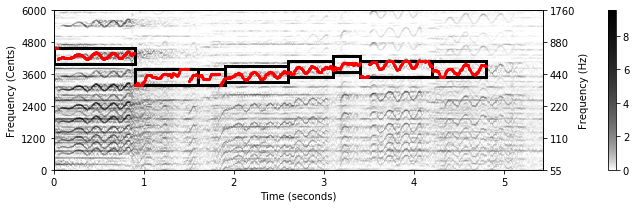

F0 sonification (right channel), original recording (left channel)


In [8]:
def convert_ann_to_constraint_region(ann, tol_freq_cents=300.0):
    """Convert score annotations to constraint regions

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        ann (list): Score annotations [[start_time, end_time, MIDI_pitch], ...
        tol_freq_cents (float): Tolerance in pitch directions specified in cents (Default value = 300.0)

    Returns:
        constraint_region (np.ndarray): Constraint regions
    """
    tol_pitch = tol_freq_cents / 100
    freq_lower = 2 ** ((ann[:, 2] - tol_pitch - 69)/12) * 440
    freq_upper = 2 ** ((ann[:, 2] + tol_pitch - 69)/12) * 440
    constraint_region = np.concatenate((ann[:, 0:2],
                                        freq_lower.reshape(-1, 1),
                                        freq_upper.reshape(-1, 1)), axis=1)
    return constraint_region

# @jit(nopython=True)
def compute_trajectory_cr(Z, T_coef, F_coef_hertz, constraint_region=None,
                          tol=5, score_low=0.01, score_high=1.0):
    """Trajectory tracking with constraint regions

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        Z (np.ndarray): Salience representation
        T_coef (np.ndarray): Time axis
        F_coef_hertz (np.ndarray): Frequency axis in Hz
        constraint_region (np.ndarray): Constraint regions, row-format: (t_start_sec, t_end_sec, f_start_hz, f_end_hz)
            (Default value = None)
        tol (int): Tolerance parameter for transition matrix (Default value = 5)
        score_low (float): Score (low) for transition matrix (Default value = 0.01)
        score_high (float): Score (high) for transition matrix (Default value = 1.0)

    Returns:
        eta (np.ndarray): Trajectory indices, unvoiced frames are indicated with -1
    """
    # do tracking within every constraint region
    if constraint_region is not None:
        # initialize contour, unvoiced frames are indicated with -1
        eta = np.full(len(T_coef), -1)

        for row_idx in range(constraint_region.shape[0]):
            t_start = constraint_region[row_idx, 0]  # sec
            t_end = constraint_region[row_idx, 1]  # sec
            f_start = constraint_region[row_idx, 2]  # Hz
            f_end = constraint_region[row_idx, 3]  # Hz

            # convert start/end values to indices
            t_start_idx = np.argmin(np.abs(T_coef - t_start))
            t_end_idx = np.argmin(np.abs(T_coef - t_end))
            f_start_idx = np.argmin(np.abs(F_coef_hertz - f_start))
            f_end_idx = np.argmin(np.abs(F_coef_hertz - f_end))

            # track in salience part
            cur_Z = Z[f_start_idx:f_end_idx+1, t_start_idx:t_end_idx+1]
            T = define_transition_matrix(cur_Z.shape[0], tol=tol,
                                         score_low=score_low, score_high=score_high)
            cur_eta = compute_trajectory_dp(cur_Z, T)

            # fill contour
            eta[t_start_idx:t_end_idx+1] = f_start_idx + cur_eta
    else:
        T = define_transition_matrix(Z.shape[0], tol=tol, score_low=score_low, score_high=score_high)
        eta = compute_trajectory_dp(Z, T)

    return eta

# Read score annotations and convert to constraint regions
ann_score_df = libfmp.b.read_csv(os.path.join('..', 'data', 'C8', 'FMP_C8_F10_Weber_Freischuetz-06_FreiDi-35-40_CR-score.csv'))
print('Score annotations:')
ipd.display(ipd.HTML(ann_score_df.to_html()))
ann_score = ann_score_df.values
constraint_region = convert_ann_to_constraint_region(ann_score, tol_freq_cents=300)
print('Constraint regions:')
print(constraint_region)

# Frequency trajectory using constraint regions
index_CR = compute_trajectory_cr(Z, T_coef, F_coef_hertz, constraint_region, tol=5)
traj = np.hstack((T_coef.reshape(-1, 1), F_coef_hertz[index_CR].reshape(-1, 1)))
traj[index_CR==-1, 1] = 0  # set unvoiced frames to zero

# Visualization
visualize_salience_traj_constraints(Z, T_coef, F_coef_cents, F_ref=F_min, figsize=figsize, cmap=cmap, 
                                    constraint_region=constraint_region, colorbar=True, traj=traj, ax=None)
plt.show()

# Sonification
x_traj_mono = sonify_trajectory_with_sinusoid(traj, len(x), Fs, smooth_len=11)
x_traj_stereo = np.vstack((x.reshape(1,-1), x_traj_mono.reshape(1,-1)))  
print('F0 sonification (right channel), original recording (left channel)')
ipd.display(ipd.Audio(x_traj_stereo, rate=Fs))

Obviously, if the score-informed constraint regions are not accurate (e.g., due to synchronization inaccuracies or deviations between the score and audio recording), the procedure becomes problematic possibly leading to a corrupted frequency trajectory. Such errors may be corrected by suitably adjusting the constraint regions. The following example shows user-optimized constraint regions along with the resulting F0-trajectory.

<!--<img src="../data/C8/FMP_C8_F17c.png" width="400px" align="middle" alt="FMP_C8_F17c">-->

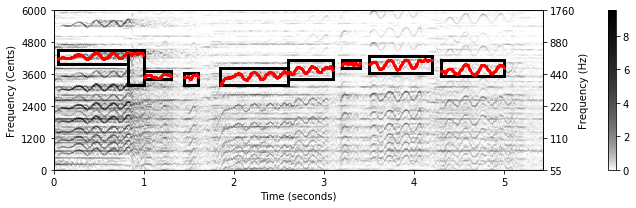

F0 sonification (right channel), original recording (left channel)


In [9]:
# Read constraint regions
constraint_region_df = libfmp.b.read_csv(os.path.join('..', 'data', 'C8', 'FMP_C8_F10_Weber_Freischuetz-06_FreiDi-35-40_CR-user.csv'))
constraint_region = constraint_region_df.values

index_CR = compute_trajectory_cr(Z, T_coef, F_coef_hertz, constraint_region, tol=5)
traj = np.hstack((T_coef.reshape(-1, 1), F_coef_hertz[index_CR].reshape(-1, 1)))
traj[index_CR==-1, 1] = 0  # set unvoiced frames to zero

# Visualization
visualize_salience_traj_constraints(Z, T_coef, F_coef_cents, F_ref=F_min, 
                                    figsize=figsize, cmap=cmap, 
                                    constraint_region=constraint_region, 
                                    colorbar=True, traj=traj, ax=None)
plt.show()

# Sonification
x_traj_mono = sonify_trajectory_with_sinusoid(traj, len(x), Fs, smooth_len=11)
x_traj_stereo = np.vstack((x.reshape(1,-1), x_traj_mono.reshape(1,-1)))  
print('F0 sonification (right channel), original recording (left channel)')
ipd.display(ipd.Audio(x_traj_stereo, rate=Fs))

# Save extracted F0 trajectory
fn_out = os.path.join('..', 'output', 'C8', 'FMP_C8_F10_Weber_Freischuetz-06_FreiDi-35-40_F0-user-FMP.csv')
pd.DataFrame(traj).to_csv(fn_out, sep=';', index=False, quoting=2, 
                                  header=['time', 'frequency'], float_format='%.4f')

## Example: Stop Messing With Me (Bornemark)

The overall procedure for constrained-based computation of F0-trajectories is summarized in the following code cell. As an example, the procedure is applied to an excerpt of the song "Stop Messing With Me" by Sven Bornemark. In the excerpt, the melody is performed by a male singer, who is accompanied by drums, piano, and guitar. We consider the case constraint regions, which encode when the singer is active and in which pitch range he is singing, are given.

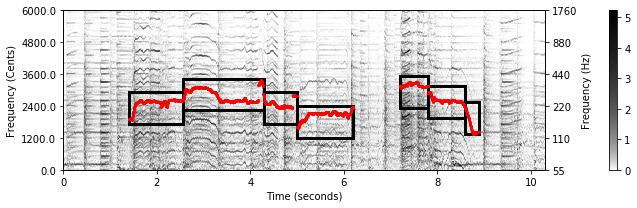

F0 sonification (right channel), original recording (left channel)


In [10]:
def compute_traj_from_audio(x, Fs=22050, N=1024, H=128, R=10.0, F_min=55.0, F_max=1760.0,
                            num_harm=10, freq_smooth_len=11, alpha=0.9, gamma=0.0,
                            constraint_region=None, tol=5, score_low=0.01, score_high=1.0):
    """Compute F0 contour from audio signal

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        x (np.ndarray): Audio signal
        Fs (scalar): Sampling frequency (Default value = 22050)
        N (int): Window length in samples (Default value = 1024)
        H (int): Hopsize in samples (Default value = 128)
        R (float): Frequency resolution in cents (Default value = 10.0)
        F_min (float): Lower frequency bound (reference frequency) (Default value = 55.0)
        F_max (float): Upper frequency bound (Default value = 1760.0)
        num_harm (int): Number of harmonics (Default value = 10)
        freq_smooth_len (int): Filter length for vertical smoothing (Default value = 11)
        alpha (float): Weighting parameter for harmonics (Default value = 0.9)
        gamma (float): Logarithmic compression factor (Default value = 0.0)
        constraint_region (np.ndarray): Constraint regions, row-format: (t_start_sec, t_end_sec, f_start_hz, f_end,hz)
            (Default value = None)
        tol (int): Tolerance parameter for transition matrix (Default value = 5)
        score_low (float): Score (low) for transition matrix (Default value = 0.01)
        score_high (float): Score (high) for transition matrix (Default value = 1.0)

    Returns:
        traj (np.ndarray): F0 contour, time in seconds in 1st column, frequency in Hz in 2nd column
        Z (np.ndarray): Salience representation
        T_coef (np.ndarray): Time axis
        F_coef_hertz (np.ndarray): Frequency axis in Hz
        F_coef_cents (np.ndarray): Frequency axis in cents
    """
    Z, F_coef_hertz, F_coef_cents = libfmp.c8.compute_salience_rep(
        x, Fs, N=N, H=H, R=R, F_min=F_min, F_max=F_max, num_harm=num_harm, freq_smooth_len=freq_smooth_len,
        alpha=alpha, gamma=gamma)

    T_coef = (np.arange(Z.shape[1]) * H) / Fs
    index_CR = compute_trajectory_cr(Z, T_coef, F_coef_hertz, constraint_region,
                                     tol=tol, score_low=score_low, score_high=score_high)

    traj = np.hstack((T_coef.reshape(-1, 1), F_coef_hertz[index_CR].reshape(-1, 1)))
    traj[index_CR == -1, 1] = 0
    return traj, Z, T_coef, F_coef_hertz, F_coef_cents

# Load audio
fn_wav = os.path.join('..', 'data', 'C8', 'FMP_C8_Audio_Bornemark_StopMessingWithMe-Excerpt_SoundCloud_mix.wav')
Fs = 22050
x, Fs = librosa.load(fn_wav, sr=Fs)
x_duration = len(x)/Fs
ipd.Audio(x, rate=Fs)

# Read constraint regions
constraint_region_df = libfmp.b.read_csv(os.path.join('..', 'data', 'C8', 'FMP_C8_F11_SvenBornemark_StopMessingWithMe_CR.csv'))
constraint_region = constraint_region_df.values

# Compute trajectory
traj, Z, T_coef, F_coef_hertz, F_coef_cents = compute_traj_from_audio(x, Fs=Fs, 
                                        constraint_region=constraint_region, gamma=0.1)

# Visualization
visualize_salience_traj_constraints(Z, T_coef, F_coef_cents, F_ref=F_coef_hertz[0], figsize=figsize, cmap=cmap, 
                                    constraint_region=constraint_region, colorbar=True, traj=traj, ax=None)
plt.show()

# Sonification
x_traj_mono = sonify_trajectory_with_sinusoid(traj, len(x), Fs, smooth_len=11)
x_traj_stereo = np.vstack((x.reshape(1,-1), x_traj_mono.reshape(1,-1)))  
print('F0 sonification (right channel), original recording (left channel)')
ipd.display(ipd.Audio(x_traj_stereo, rate=Fs))

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a> and <a href="https://www.audiolabs-erlangen.de/fau/assistant/rosenzweig">Sebastian Rosenzweig</a>.</div> 

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>